# Chapter 3
#### Setion 3.6: Implementation of Softmax Regression from Scratch

In [1]:
import torch
from IPython import display
from d2l import torch as d2l

#### Initializing Model Parameters

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

'''
for X, y in train_iter:
    #print(X.shape)
    # 32 samples, 1 channel, antes 28x28 px^2 ahora de 64*64 px^2  to test the image resizing feature 
    print(X.dtype)
    print(y.shape)
    print(y.dtype)
    break
'''

'\nfor X, y in train_iter:\n    #print(X.shape)\n    # 32 samples, 1 channel, antes 28x28 px^2 ahora de 64*64 px^2  to test the image resizing feature \n    print(X.dtype)\n    print(y.shape)\n    print(y.dtype)\n    break\n'

In [3]:
'''
Each image sample in the dataset is a 28×28 , we will flatten each image, treating them as
vectors of length 784. So we treat each pixel location as just another feature.

Recall that in softmax regression, we have as many outputs as there are classes. 
So we have the output dimension of 10. Consequently, the weights will be a 784×10
matrix and the biases will constitute a 1×10 row vector. 
'''
num_inputs = 784
num_outputs = 10

# As with linear regression, we will initialize our weights W with Gaussian noise and 
# our biases to take the initial value 0.


W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)


#### Defining the Softmax Operation

In [4]:
print("TEST: sum along an axis")

# 2x3
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
# axis 0: suma columnas, resulting in 1x3
# axis 1: suma filas, resulting in 2x1
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

TEST: sum along an axis


(tensor([[5., 7., 9.]]), tensor([[ 6.],
         [15.]]))

In [5]:
# softmax (O) = exp O / Sum 
#def softmax(O):
#    O_exp = torch.exp(O)
    #print("O_exp.shape: ", O_exp.shape)
    # Sum 1 to q (number of classes 10)
#    partition = O_exp.sum(1, keepdim=True)
#    return O_exp / partition  # The broadcasting mechanism is applied here


In [6]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # The broadcasting mechanism is applied here


In [7]:
print("TEST: funcion softmax")
# mean (Tensor) – the tensor of per-element means
# std (float, optional) – the standard deviation for all distributions
# size

X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1) # Axis 1 (files)

TEST: funcion softmax


(tensor([[0.1519, 0.0740, 0.3507, 0.1479, 0.2755],
         [0.0210, 0.1006, 0.6708, 0.1339, 0.0737]]), tensor([1., 1.]))

In [8]:
# Returns Y__hat
#def net(X):
    # -1 dim to gess the proper shape if the other dim is defined
    # W: feat (784) x num_outputs (10)
    # so X*W has to be of size samples * feat (W.shape[0])
#    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)


#### Cross-entropy Loss Function

In [9]:
# IDX of classes for each sample
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])

print("TEST: pick the elements [0,0] & [1,2] of y_hat")
print("y_hat: ",y_hat)
#pick the elements 0,0 & 1,2
y_hat[[0, 1], y]


TEST: pick the elements [0,0] & [1,2] of y_hat
y_hat:  tensor([[0.1000, 0.3000, 0.6000],
        [0.3000, 0.2000, 0.5000]])


tensor([0.1000, 0.5000])

In [10]:
# Loss function: cross_entropy(y_hat, y)
# Claro si el termino de mayor probabilidad es 1 la perdida es 0! (log(1) = 0)
def cross_entropy(y_hat, y):
    #print(len(y_hat))
    #print(y_hat[range(len(y_hat)), y])
    # exponente yj solo filtra la componente correcta de y_hat
    return - torch.log(y_hat[range(len(y_hat)), y])

#import numpy as np
#np.log(0.5000)

print("TEST: cross_entropy(y_hat, y) - exponente yj solo filtra la componente correcta de y_hat")

cross_entropy(y_hat, y)


TEST: cross_entropy(y_hat, y) - exponente yj solo filtra la componente correcta de y_hat


tensor([2.3026, 0.6931])

#### Classification Accuracy

In [11]:
# The classification accuracy is the fraction of all predictions that are correct.
# Aca y son los indices de las clases
def accuracy(y_hat, y):  #@save
    """Compute the number of correct predictions."""
    #print("y_hat.shape: ",y_hat.shape)
    #print("len(y_hat.shape): ",len(y_hat.shape))
    #len(y_hat.shape):  2
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
        #print("y_hat max idx:", y_hat)
    # Aca piso y_hat y ahora tiene los indices que son arg max para cada fila
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [12]:
print("TEST: accuracy")
accuracy(y_hat, y) / len(y)


TEST: accuracy


0.5

In [13]:
class Accumulator:  #@save
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # La cantidad de variables que necesito ir acumulando

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
def evaluate_accuracy(net, data_iter):  #@save
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions

    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

    
# batch size x number of classes: 256x10 
#y_hat.shape:  torch.Size([256, 10])

In [14]:
evaluate_accuracy(net, test_iter)

0.1225

#### Training

In [15]:
# One epoch
# net: input X and output Y_hat, using softmax
# train_iter 
#torch.Size([256, 1, 28, 28]) batch size por 1 canal por px*px
#torch.float32
#torch.Size([256])
# loss(y_hat, y) son los -log y_hat de la componente de esa clase que correspone al label

def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Necesito acumular tres variables:
    # Sum of training loss (de la cross entropy o loss fn.), sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # Using PyTorch in-built optimizer & loss criterion
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # Using custom built optimizer & loss criterion
            l.sum().backward()
            # Update parameters using their gradient stochastic gradient Descent
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
        #print("y.numel():", y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [16]:
class Animator:  #@save
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [17]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """Train a model (defined in Chapter 3)."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc


In [18]:
lr = 0.1

def updater(batch_size):
    # Update parameters using their gradient
    return d2l.sgd([W, b], lr, batch_size)

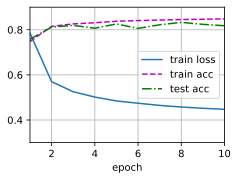

In [19]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

#### Prediction

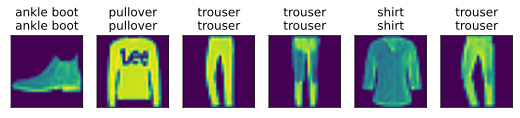

In [20]:
def predict_ch3(net, test_iter, n=6):  #@save
    """Predict labels (defined in Chapter 3)."""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)